# WP10 Computergestützte Biologie I: Mathematische Modelle dynamischer Systeme (SoSe24)
## Woche 05

Teil der heutigen Übung ist:

    Analyse des Hodgkin-Huxley Modells.

Die Gleichungen sind:

$$
\left(\begin{array}{c} 
\frac{dV}{dt} \\
\frac{dm}{dt} \\
\frac{dn}{dt} \\
\frac{dh}{dt} \\
\end{array}\right)
=
\left(\begin{array}{c} 
\dfrac{1}{c_m}\left[-\sum_k I_k(t) + I(t) \right] \\ 
\alpha_m(V)(1-m)-\beta_m(V)m \\
\alpha_n(V)(1-n)-\beta_n(V)n \\
\alpha_h(V)(1-h)-\beta_h(V)h \\
\end{array}\right)
$$ 

Wobei

$$
\sum_k I_k(t) = g_{Na}m^3h(V-E{Na})+g_K n^4 (V-E_K) + g_L(V-E_L)
$$
$$
\alpha_m(V) = \dfrac{0.1(V+40)}{1-\exp(-\frac{V+40}{10})}
$$

$$
\alpha_n[V) = \dfrac{0.01(V+55)}{1-\exp(-\frac{V+55}{10})}
$$

$$
\alpha_h(V) = 0.07 \exp(-\frac{V+65}{20})
$$

$$
\beta_m(V) =  4 \exp(-\frac{V+65}{18})
$$

$$
\beta_n(V) =  0.125 \exp(-\frac{V+65}{80})
$$

$$
\beta_h(V) = \dfrac{1}{1+\exp(-\frac{V+35}{10})}
$$

$$
c_m = 1
$$

# Einheiten
Wir nutzen im Folgenden die Einheiten:

- Zeit t: $~~ms$
- Spannung v:  $~~mV$
- Stromstärke i:  $~~uA/cm^2$
- Membrankapazität $c_m$:  $~~uF/cm^2$
- Leitfähigkeit g:  $~~mS/cm^2$

In [26]:
import scipy as sp
import numpy as np
import pylab as plt
from scipy.integrate import odeint
import copy

class HodgkinHuxley():
    """
    Full Hodgkin-Huxley Model implemented in Python
    based on:
    https://hodgkin-huxley-tutorial.readthedocs.io/
    en/latest/_static/Hodgkin%20Huxley.html?msclkid
    =8be97e4ac6c011ecb09da5754c9af3d8
    """

    C_m  =   1.0
    """membrane capacitance, in uF/cm^2"""

    g_Na = 120.0
    """Sodium (Na) maximum conductances, in mS/cm^2"""

    g_K  =  36.0
    """Postassium (K) maximum conductances, in mS/cm^2"""

    g_L  =   0.3
    """Leak maximum conductances, in mS/cm^2"""

    E_Na =  50.0
    """Sodium (Na) Nernst reversal potentials, in mV"""

    E_K  = -77.0
    """Postassium (K) Nernst reversal potentials, in mV"""

    E_L  = -54.387
    """Leak Nernst reversal potentials, in mV"""
    
    # initialize all variables of solution
    v = np.array([],dtype=float)
    m = np.array([],dtype=float)
    h = np.array([],dtype=float)
    n = np.array([],dtype=float)
    ina = np.array([],dtype=float)
    ik = np.array([],dtype=float)
    il = np.array([],dtype=float)
    iin = np.array([],dtype=float)
    
    def __init__(self, run_time=450.,v0=-65., m0=0.05, h0=0.6, n0=0.32, i_inj=None, mode='current_clamp' ):
        """
        run_time: [ms]
        v0, m0, h0, n0: initial values
        i_inj: Python function returning the electrode current at time t
        
        mode: solution can be found under "current_clamp" oder "voltage_clamp"
        """
        self.mode = mode
        self.run_time = run_time
        self.v0 = v0
        self.m0 = m0 
        self.h0 = h0
        self.n0 = n0
        
        # The time to integrate over
        self.t = np.arange(0.0, self.run_time, 0.01)
            
        if self.mode=='current_clamp':  
            if i_inj == None:
                self.I_inj = self.i_inj
            else:
                self.I_inj = i_inj         
        elif self.mode == "voltage_clamp":
            self.I_inj = lambda t: 0.          

    def alpha_m(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.1*(V+40.0)/(1.0 - np.exp(-(V+40.0) / 10.0))

    def beta_m(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 4.0*np.exp(-(V+65.0) / 18.0)

    def alpha_h(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.07*np.exp(-(V+65.0) / 20.0)

    def beta_h(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 1.0/(1.0 + np.exp(-(V+35.0) / 10.0))

    def alpha_n(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.01*(V+55.0)/(1.0 - np.exp(-(V+55.0) / 10.0))

    def beta_n(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.125*np.exp(-(V+65) / 80.0)

    def I_Na(self, V, m, h):
        """
        Membrane current (in uA/cm^2)
        Sodium (Na = element name)

        |  :param V:
        |  :param m:
        |  :param h:
        |  :return:
        """
        return self.g_Na * m**3 * h * (V - self.E_Na)

    def I_K(self, V, n):
        """
        Membrane current (in uA/cm^2)
        Potassium (K = element name)

        |  :param V:
        |  :param h:
        |  :return:
        """
        return self.g_K  * n**4 * (V - self.E_K)
    #  Leak
    def I_L(self, V):
        """
        Membrane current (in uA/cm^2)
        Leak

        |  :param V:
        |  :param h:
        |  :return:
        """
        return self.g_L * (V - self.E_L)

    def i_inj(self, t):
        """
        External Current

        |  :param t: time
        |  :return: step up to 10 uA/cm^2 at t>100
        |           step down to 0 uA/cm^2 at t>200
        |           step up to 35 uA/cm^2 at t>300
        |           step down to 0 uA/cm^2 at t>400
        """
        return 10*(t>100) - 10*(t>200) + 35*(t>300) - 35*(t>400)
    
    def dVdt(self, t, V, m, n, h):
        return (self.I_inj(t) - self.I_Na(V, m, h) - self.I_K(V, n) - self.I_L(V)) / self.C_m
    
    def dmdt(self, t, V, m, n, h):
        return self.alpha_m(V)*(1.0-m) - self.beta_m(V)*m
    
    def dndt(self, t, V, m, n, h):
        return self.alpha_n(V)*(1.0-n) - self.beta_n(V)*n
    
    def dhdt(self, t, V, m, n, h):
        self.alpha_h(V)*(1.0-h) - self.beta_h(V)*h
    
    @staticmethod
    def dALLdt_current(X, t, self):
        """
        Integrate

        |  :param X:
        |  :param t:
        |  :return: calculate membrane potential & activation variables
        """
        V, m, h, n = X

        dVdt = (self.I_inj(t) - self.I_Na(V, m, h) - self.I_K(V, n) - self.I_L(V)) / self.C_m
        dmdt = self.alpha_m(V)*(1.0-m) - self.beta_m(V)*m
        dhdt = self.alpha_h(V)*(1.0-h) - self.beta_h(V)*h
        dndt = self.alpha_n(V)*(1.0-n) - self.beta_n(V)*n
        return dVdt, dmdt, dhdt, dndt
    
    @staticmethod
    def dALLdt_voltage(X, t, self):
        """
        Integrate

        |  :param X:
        |  :param t:
        |  :return: calculate membrane potential & activation variables
        unter voltage clamp the membrane voltage does not change
        """
        V, m, h, n = X

        dVdt = 0.
        dmdt = self.alpha_m(V)*(1.0-m) - self.beta_m(V)*m
        dhdt = self.alpha_h(V)*(1.0-h) - self.beta_h(V)*h
        dndt = self.alpha_n(V)*(1.0-n) - self.beta_n(V)*n
        return dVdt, dmdt, dhdt, dndt

    def solve(self, dALLdt, t):
        
        X = odeint(dALLdt, [self.v0, self.m0, self.h0, self.n0], t, args=(self,))
        self.v = np.concatenate((self.v,  X[:,0]))
        self.m = np.concatenate((self.m,  X[:,1]))
        self.h = np.concatenate((self.h,  X[:,2]))
        self.n = np.concatenate((self.n,  X[:,3]))
        self.ina = np.concatenate((self.ina,  self.I_Na(X[:,0], X[:,1], X[:,2]) ))
        self.ik = np.concatenate((self.ik, self.I_K(X[:,0], X[:,3]) ))
        self.il = np.concatenate((self.il, self.I_L(X[:,0]) ))
        self.iin = np.concatenate((self.iin, [self.I_inj(ti) for ti in t] ))
        
    def run(self, display_results=True):
        """
        Main demo for the Hodgkin Huxley neuron model
        """
        
        if not self.mode in ['current_clamp', "voltage_clamp" ]:
            print('unknown mode. mode set to current clamp')
            self.mode ='current_clamp'
            
        if self.mode == "voltage_clamp":
            self.solve(dALLdt=self.dALLdt_current, t=self.t[:3000]) # let system equilibrate und zero current current clamp condition
            self.solve(dALLdt=self.dALLdt_voltage, t=self.t[3000:])  # voltage clamp until end with intial voltage
        else:
            self.solve(dALLdt=self.dALLdt_current, t=self.t)
        
        if display_results: 
            plt.figure(dpi=150)

            plt.subplot(4,1,1)
            plt.title('Hodgkin-Huxley Neuron')
            plt.plot(self.t, self.v, 'k')
            plt.ylabel('V (mV)')

            plt.subplot(4,1,2)
            plt.plot(self.t, -self.ina, 'c', label='$I_{Na}$')
            plt.plot(self.t, -self.ik, 'y', label='$I_{K}$')
            plt.plot(self.t, -self.il, 'm', label='$I_{L}$')
            plt.ylabel('Current\n [$\\mu A/cm^2$]')
            plt.legend()

            plt.subplot(4,1,3)
            plt.plot(self.t, self.m, 'r', label='m')
            plt.plot(self.t, self.h, 'g', label='h')
            plt.plot(self.t, self.n, 'b', label='n')
            plt.ylabel('Gating Value')
            plt.legend()

            plt.subplot(4,1,4)
            plt.plot(self.t, self.iin, 'k')
            plt.xlabel('t (ms)')
            plt.ylabel('$I_{inj}$ \n($\\mu{A}/cm^2$)')
            plt.ylim(-1, 40)

            plt.tight_layout()
            plt.show()

    
    def show_transition_probabilities(self):
        
        plt.figure(dpi=150)
        
        
        plt.subplot(3,1,1)
        plt.title('activation and inactvation variables')
        plt.plot(self.t,(1.-self.n)*self.alpha_n(self.v), label='$(1-n) \\alpha_n$')
        plt.plot(self.t,self.n*self.beta_n(self.v), label='$n \\beta_n$')
        #plt.ylabel('$\\alpha_n$ $\\beta_n$')
        plt.legend()
        
        plt.subplot(3,1,2)
        plt.plot(self.t,(1.-self.h)*self.alpha_h(self.v), label='$(1-h) \\alpha_h$')
        plt.plot(self.t,self.h*self.beta_h(self.v), label='$h \\beta_h$')
        #plt.ylabel('$\\alpha_h$ $\\beta_h$')
        plt.legend()
        
        plt.subplot(3,1,3)
        plt.plot(self.t,(1.-self.m)*self.alpha_m(self.v), label='$(1-m) \\alpha_m$')
        plt.plot(self.t,self.m*self.beta_m(self.v), label='$m \\beta_m$')
        #plt.ylabel('$\\alpha_m$ $\\beta_m$')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
    def show_channel_open_prob(self):
        
        plt.figure(dpi=150)
        
        plt.subplot(211)
        plt.title('Activity of Ion-Channels')
        plt.plot(self.t, np.power(self.n,4), label='n^4')
        plt.ylabel('Potassium')
        plt.legend()
        
        plt.subplot(212)
        plt.plot(self.t, np.power(self.m,3), label='$m^3$')
        plt.plot(self.t, self.h, label='h')
        plt.plot(self.t, self.h*np.power(self.m,3), label='$hm^3$')
        plt.ylabel('Sodium')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
    def show_channel_voltage(self):
        
        plt.figure(dpi=150)
        
        plt.subplot(311)
        plt.title('Ion-Channel Voltage')
        plt.plot(self.t, self.v-self.E_K, label='$V - E_K$')
        plt.ylabel('Potassium')
        plt.legend()
        
        plt.subplot(312)
        plt.plot(self.t, self.v-self.E_Na, label='V - E_{Na}')
        plt.ylabel('Sodium')
        plt.legend()
        
        plt.subplot(313)
        plt.plot(self.t, self.v-self.E_L, label='V - E_L')
        plt.ylabel('Leakage')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
    def show_phase_space_trajectory(self):
        
        plt.figure(dpi=150)
        
        plt.subplot(221)
        plt.plot(self.v, self.n)
        plt.xlabel('v [mV]')
        plt.ylabel('n ')
        
        plt.subplot(222)
        plt.plot(self.v, self.h)
        plt.xlabel('v [mV]')
        plt.ylabel('h')
        
        plt.subplot(223)
        plt.plot(self.v, self.m)
        plt.xlabel('v [mV]')
        plt.ylabel('m')
        
        plt.subplot(224)
        plt.plot(self.v, self.ina+self.ik+self.il+self.iin)
        plt.xlabel('v [mV]')
        plt.ylabel('kapazitiver Strom [$\\mu A/cm^2$]')
        
        plt.tight_layout()
        plt.show()
     
    def animation_phase_space_trajectory(self):
        import time
        def update(ax, var1, var2, n):
            if ax.lines:
                
                line = ax.lines[0]
                line.set_xdata(var1[:n])
                line.set_ydata(var2[:n])
                dot = ax.lines[1]
                dot.set_xdata([var1[n-2:n]])
                dot.set_ydata([var2[n-2:n]])                
            else: 
                ax.plot(var1[:n], var2[:n])
                ax.plot([var1[n:n+2]],[var2[n:n+2]],'r-', lw=2.)
                
                
            fig.canvas.draw()   
            time.sleep(0.03)
        
        fig = plt.figure(dpi=150)  
        
        
        ax1 = fig.add_subplot(221)
        ax1.set_xlabel('v [mV]')
        ax1.set_ylabel('h')
        ax1.set_xlim(-100.,50.)
        ax1.set_ylim(0.,1.)
        
        ax2 = fig.add_subplot(222)
        ax2.set_xlabel('v [mV]')
        ax2.set_ylabel('m')
        ax2.set_xlim(-100.,50.)
        ax2.set_ylim(0.,1.)
        
        ax3 = fig.add_subplot(223)
        ax3.set_xlabel('v [mV]')
        ax3.set_ylabel('n')
        ax3.set_xlim(-100.,50.)
        ax3.set_ylim(0.,1.)
        
        ax4 = fig.add_subplot(224)
        ax4.set_xlabel('v [mV]')
        ax4.set_ylabel('i')
        ax4.set_xlim(-100.,50.)
        ax4.set_ylim(-500.,500.)
        
        plt.tight_layout()

        i_tot = self.ina+self.ik+self.il+self.iin
        
        i=0
        t= self.t[i]
        V, m, h, n = self.v[i], self.m[i], self.h[i], self.m[i]
        x,y = np.meshgrid(np.linspace(-100.,50.,15),\
              np.linspace(0. ,1. ,15)
              )
        dx = (self.I_inj(t) - self.I_Na(x, m, y) - self.I_K(x, n) - self.I_L(x)) / self.C_m
        dy = self.alpha_h(x)*(1.0-y) - self.beta_h(x)*y       
        q = ax1.quiver(x,y,dx,dy)
        
        
        for i in range(50,len(self.t),50):
            update(ax1, self.v, self.h, i)
            update(ax2, self.v, self.m, i)
            update(ax3, self.v, self.n, i)
            update(ax4, self.v, i_tot, i)
            
            if i % 50 == 0:
                t= self.t[i]
                V, m, h, n = self.v[i], self.m[i], self.h[i], self.m[i]
                x,y = np.meshgrid(np.linspace(-100.,50.,15),\
                      np.linspace(0. ,1. ,15)
                      )
                dx = (self.I_inj(t) - self.I_Na(x, m, y) - self.I_K(x, n) - self.I_L(x)) / self.C_m
                dy = self.alpha_h(x)*(1.0-y) - self.beta_h(x)*y       
                q.set_UVC(dx,dy)
            

        
    def get_average_firing_rate(self):
        tmp = copy.copy(self.v)
        # count how often voltage changes sign and divide by two to get number of spikes
        tmp = np.sign(tmp)
        tmp[1:] =tmp[:-1] * tmp[1:]
        tmp[0] = 1
        count = np.sum(tmp < 0.) /2.
        rate = count / self.run_time
        return rate * 1000. # convert from 1/ms to 1/sec
    


## Aufgabe 1 Simulation des HH-Neurons

Simulieren Sie das Hodgink-Huxley Neuron für den Standard-Input-Strom. Führen Sie dazu die folgende Code-Zelle aus.
- Erklären Sie die Abbildung und die darin visulisierten Variablen.
- Wie viele abhängige Variablen gibt es in dem Modell? Und welche sind es?
- Erklären Sie außerdem: Was bedeutet "Current-Clamp"?
- Geben Sie Biophysikalische Interpretation der Gatingvariablen m, n und h. 

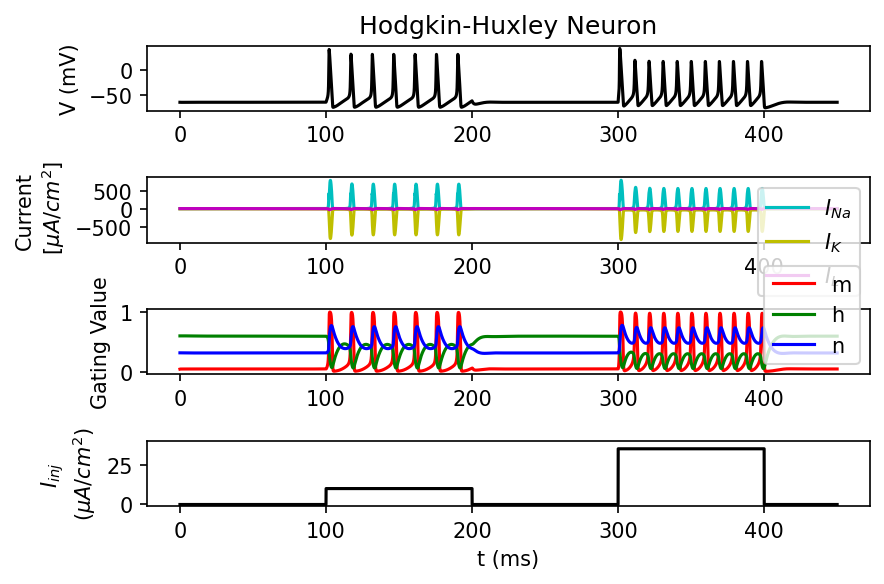

In [22]:
hh_cell = HodgkinHuxley()
hh_cell.run()

## Aufgabe 2: Bifurkation

Genau wie im LIF-Neuron oder im FitzHugh-Nagumo-Modell gibt es eine Schwelle (Threshold) ab dem ein konstanter Inputstrom zur Erzeugung eines Aktionspotentials führt.

Führen Sie die folgende Code-Zelle aus und variieren Sie dabei den Input-Strom zwischen $0 \mu A/cm^2$ und $10 \mu A/cm^2$. Analysieren Sie die Simulationsergebnisse und beantworten Sie die folgenden Fragen:

- Finden Sie die Schwelle zur Erzeugung eines Aktionspotentials.
- Wann konvergiert das HH-Neuron zu einem stabilen Fixpunkt und wann nicht?
- Erklären Sie Ihre Beobachtung anhand Ihres Wissens über Fixpunkte und Bifurkationen in Systemen mit zwei abhängigen Variablen und Vergleichen Sie das Verhalten des Hodgkin-Huxley Neurons mit dem des FitzHugh-Nagumo-Modells.

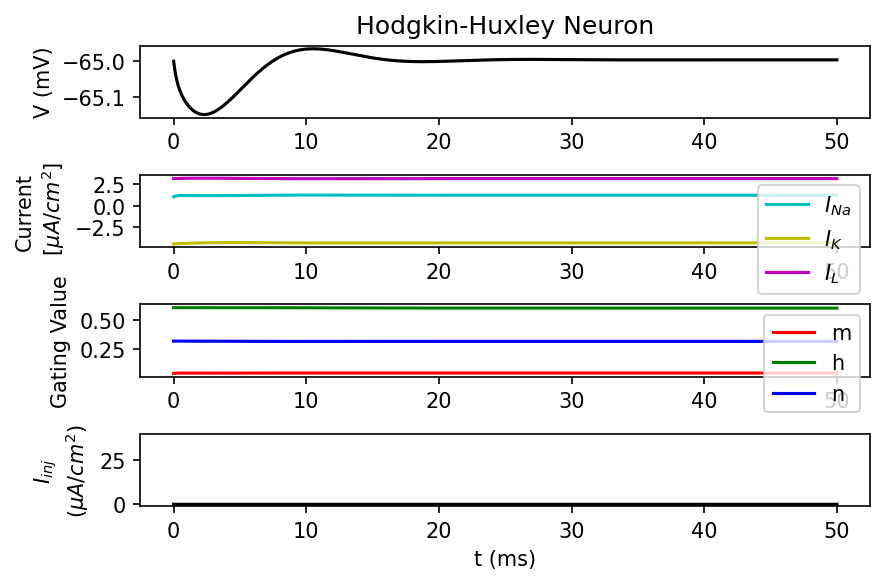

In [23]:
const_current_amplitude = 0.0 # muA/cm^2
i_constant = lambda t : const_current_amplitude
hh_cell = HodgkinHuxley(run_time=50, i_inj=i_constant)
hh_cell.run()

## Aufgabe 3: Phasenraum

Führen Sie die folgende Code-Zelle aus und beantworten Sie die folgenden Fragen:

- Beschreiben Sie die Phasenraumtrajektorien. Machen Sie sich klar, dass Sie periodische Lösungen gefunden haben.
- Im Falle periodischer Lösungen: Erklären Sie, warum jede der vier Gleichungen des HH-Neurons, wenn Sie einzeln betrachtet werden, immer einen Fixpunkt besitzt, aber das gekoppelte System nicht gegen einen Fixpunkt konvergiert.



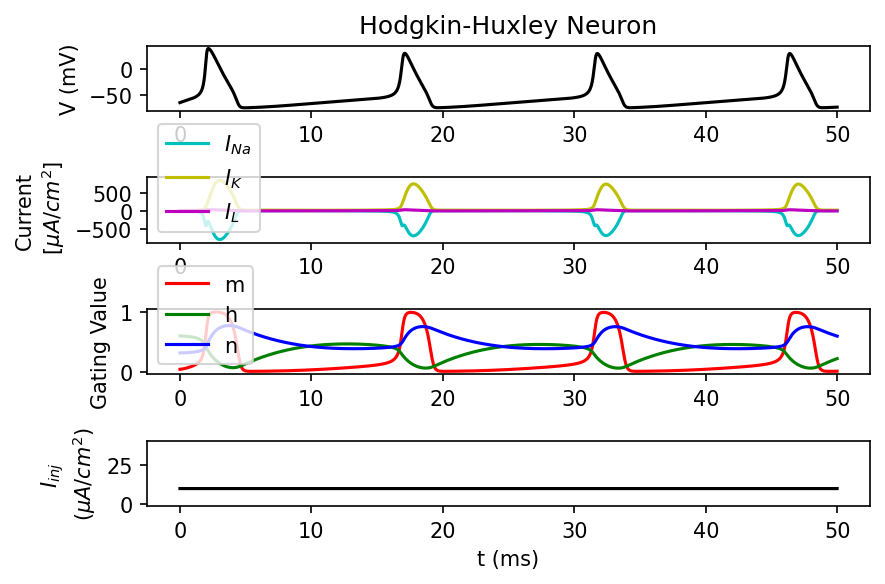

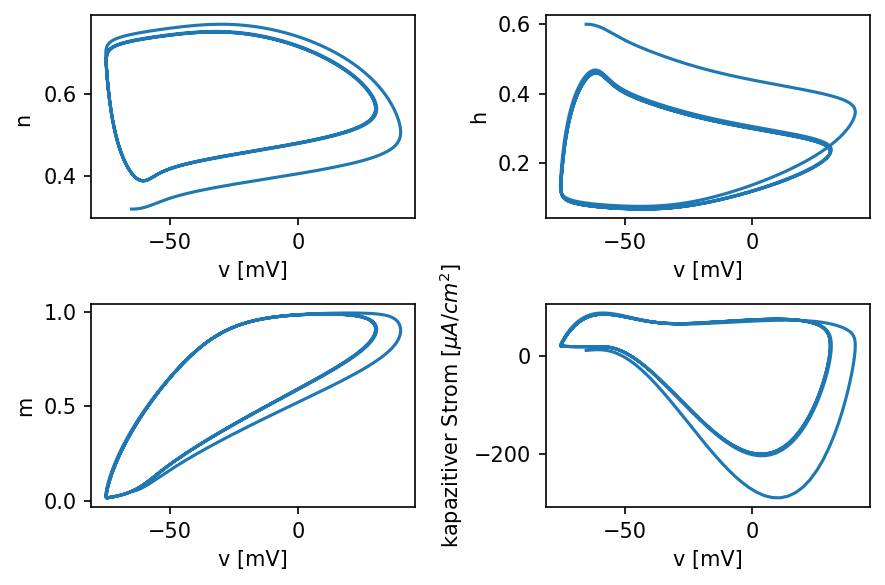

In [10]:
const_current_amplitude = 10.0 # muA/cm^2
i_constant = lambda t : const_current_amplitude
hh_cell = HodgkinHuxley(run_time=50, i_inj=i_constant)
hh_cell.run()
hh_cell.show_phase_space_trajectory()

## Aufgabe 4 Membranströme

Wir untersuchen, wie das Zusammenspiel der verschiedenen Ströme zu einer Spannungsänderung führt.

Führen Sie die beiden folgenden Zellen aus und beantworten Sie die Fragen:

- Welche Ströme gibt es im Ruhezustand?
- Welche Ströme fließen währen eines Aktionspotentials?
- Wie lassen sich aus den Gating-Variablen und der Membranspannung die Stromstärken berechnen?
- Was bedeutet ein negatives oder ein positive Vozeichen des Stroms? Welche Ströme fließen in welche Richtung?

Erklären Sie wie die zeitleich Verlauf der Ströme währende des Aktionspotentials und wie dies zur beobachteten Änderung des Membranpotentials führt.


- Welcher Kanal öffnet zuerst?
- Welchen Strom erzeugt er (Richtung, Vorzeichen)?
- Wie verändert dieser das Membranpotential?
- Welcher Strom repolarisiert und hyperpolarisiert die Zelle dann.

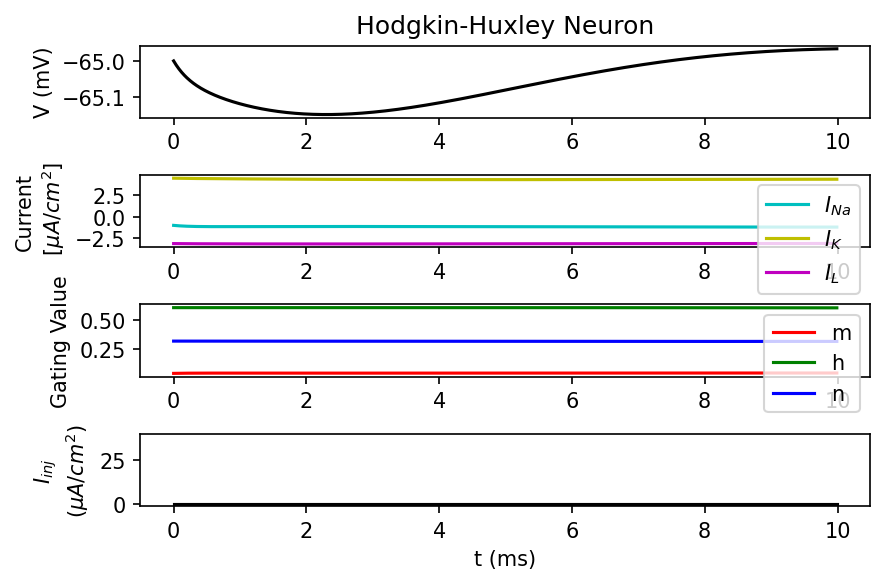

In [11]:
const_current_amplitude = 0.0 # muA/cm^2
i_constant = lambda t : const_current_amplitude
hh_cell = HodgkinHuxley(run_time=10, i_inj=i_constant)
hh_cell.run()

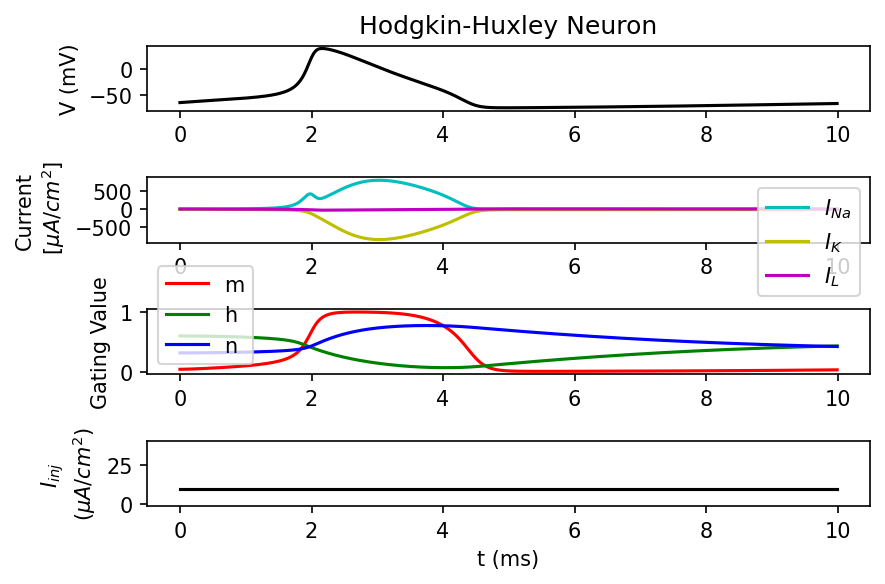

In [24]:
const_current_amplitude = 10.0 # muA/cm^2
i_constant = lambda t : const_current_amplitude
hh_cell = HodgkinHuxley(run_time=10, i_inj=i_constant)
hh_cell.run()


# Voltage Clamp

In unseren bisherigen Simulationen haben wir den Elektrodenstrom festgelegt.
Über eine Elektrode kann jedoch nicht nur ein Strom injiziert werden, sondern statt dessen auch das Membranpotential kontrolliert werden. 

Welche Folgen hat eine konstante Membranspannung auf die vier Gleichungen des HH-Modells?

Die drei Gleichungen für Gatingvariablen n, m und h haben die selbe Form und wir untersuchen $x$ stellvertretend.

$$
\dfrac{dx}{dt} = \alpha_x(V) (1-x)-\beta_x(V) x
$$

Wir formen um erhalten:
$$
\dfrac{1}{\alpha_x(V) + \beta_x(V)} \dfrac{dx}{dt}= -x + \dfrac{\alpha_x(V)}{\alpha_x(V) + \beta_x(V)}
$$

Im Voltage-Clamp Fall gilt nun $V=const$ und deshalb $\dfrac{dV}{dt}=0$.

Wir definieren deshalb die Zeitkonstane $\tau_x$ und die stationäre Lösung $x_\infty$ 

$$
\tau_x = \dfrac{1}{\alpha_x + \beta_x}
$$

$$
x_\infty = \dfrac{\alpha_x}{\alpha_x + \beta_x}
$$

und erhalten eine linear DGL erster Ordnung die den zeitlichen Verlauf der Gatingvariablen beschreibt.
$$
\tau_x \dfrac{dx}{dt} = -x + x_\infty
$$

Da außerdem \dfrac{dV}{dt}=0$ gilt, besteht das System nun aus drei ungekoppelten linearen DGLn.


## Aufgabe 5: Übergangswahrscheinlichkeiten

Visualisieren Sie die Überganswahrscheinlichkeiten $\alpha_x$ und $\beta_x$ im Bereich $-80mV<V<0mV$.

- 
- Welche bedeutung haben die Funktionen $\alpha_x(V)$ und $\beta_x(V)$?
- Welche physikalische Einheit haben $\alpha_x(V)$ und $\beta_x(V)$?
- Interpretieren Sie $(1-x)\alpha_x(V)$ und $x \beta_x(V)$
- Wie verhält sich $\tau_x$ und $x_{\infty}$ für $V\rightarrow +\infty$ und $V\rightarrow -\infty$?

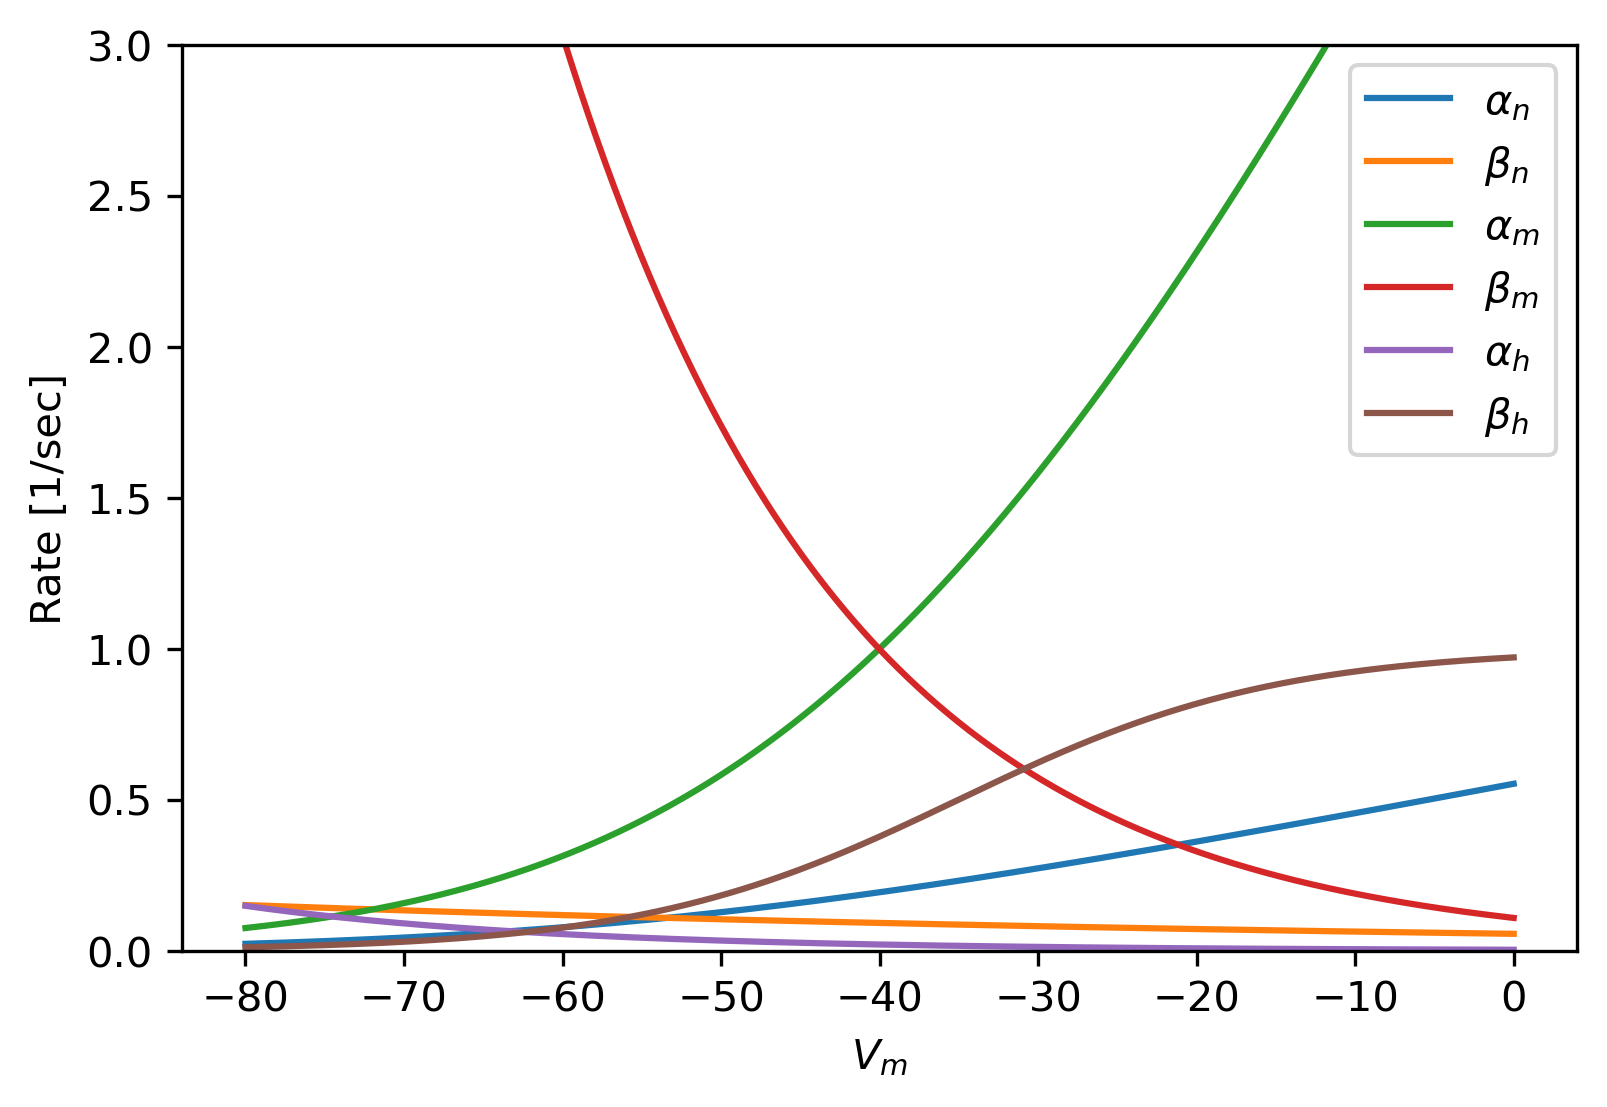

In [13]:
v = np.linspace(-80, 0, 1000)
alpha_n = hh_cell.alpha_n(v)
beta_n = hh_cell.beta_n(v)
alpha_m = hh_cell.alpha_m(v)
beta_m = hh_cell.beta_m(v)
alpha_h = hh_cell.alpha_h(v)
beta_h = hh_cell.beta_h(v)
plt.figure(dpi=300)
plt.plot(v, alpha_n, label=r'$\alpha_n$')
plt.plot(v, beta_n, label=r'$\beta_n$')
plt.plot(v,alpha_m, label=r'$\alpha_m$')
plt.plot(v,beta_m, label=r'$\beta_m$')
plt.plot(v,alpha_h, label=r'$\alpha_h$')
plt.plot(v,beta_h, label=r'$\beta_h$')
plt.ylim(0,3)
plt.xlabel('$V_m$')
plt.ylabel('Rate [1/sec]')
plt.legend()
plt.show()

## Aufgabe 6: Gating Variablen unter Voltage Clamp

Unter Voltage-Clamp lässt sich die Dynamik der Gating-Varibalen durch folgende DGL beschreiben.
$$
\dfrac{dx}{dt} = f(x,t) = \dfrac{1}{\tau_x}(-x + x_\infty)
$$

- Lösen Sie die DGL analytisch für die Anfangsbedingung $x(t=0)=x_0$.
- Berechnen sie $\tau_m$ und $m_\infty$ für den Fall $V_= -100 mV$ und $V_= 0 mV$.
- Visulasieren Sie $f(m,t)$ für die Fälle $V\in\{-100mV, -75mV, -50mV, -25mV, 0mV\}$
- Erklären Sie warum $n,m,h$ gegen eine stationäre Lösung konvergieren. Tip: Stabilität von Fixpunkten!
- Welche Werte haben die stationären Lösungen?





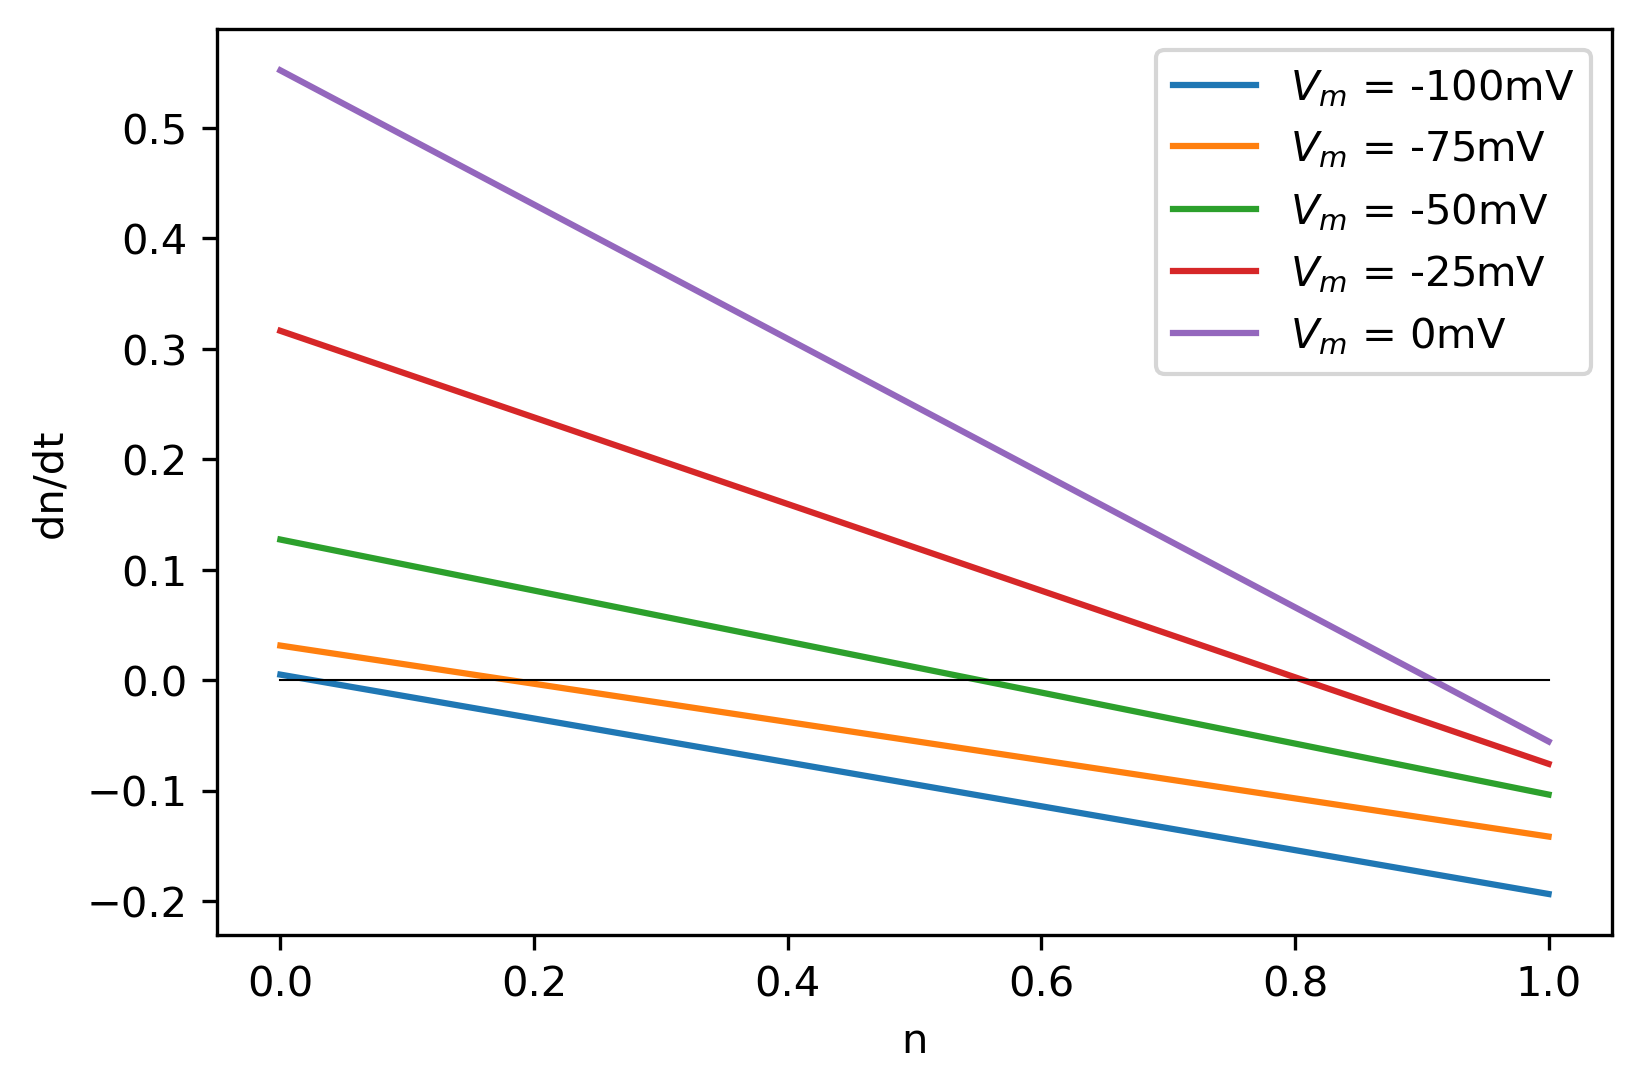

In [14]:
v = np.linspace(-100, 0, 1000)
alpha_n = hh_cell.alpha_n(v)
beta_n = hh_cell.beta_n(v)
n,m = np.linspace(0, 1, 1000), np.linspace(0, 1, 1000)
plt.figure(dpi=300)
for i in [0,250,500,750,999]:

    v_i = i*0.1-100
    a, b = alpha_n[i], beta_n[i]
    plt.plot(n, a*(1-n)-b*(n), label='$V_m$ = '+str(round(v_i))+'mV')

plt.plot(n,n*0., lw=0.5, color='k')
plt.xlabel('n')
plt.ylabel('dn/dt')
plt.legend()
plt.show()

## Aufgabe 7: 
Visualisieren Sie $\tau_m$, $\tau_n$, $\tau_h$ sowie $m_{\infty}$, $n_{\infty}$, $h_{\infty}$.

- Was bedeuten groß oder kleiner Werte von $\tau$ für die dynamik der Kanäle?
- Können Sie aus der Spannungsabhängigkeit von $m_{\infty}$, $n_{\infty}$, $h_{\infty}$ schließen wann die Kanäle öffnen und schließen?

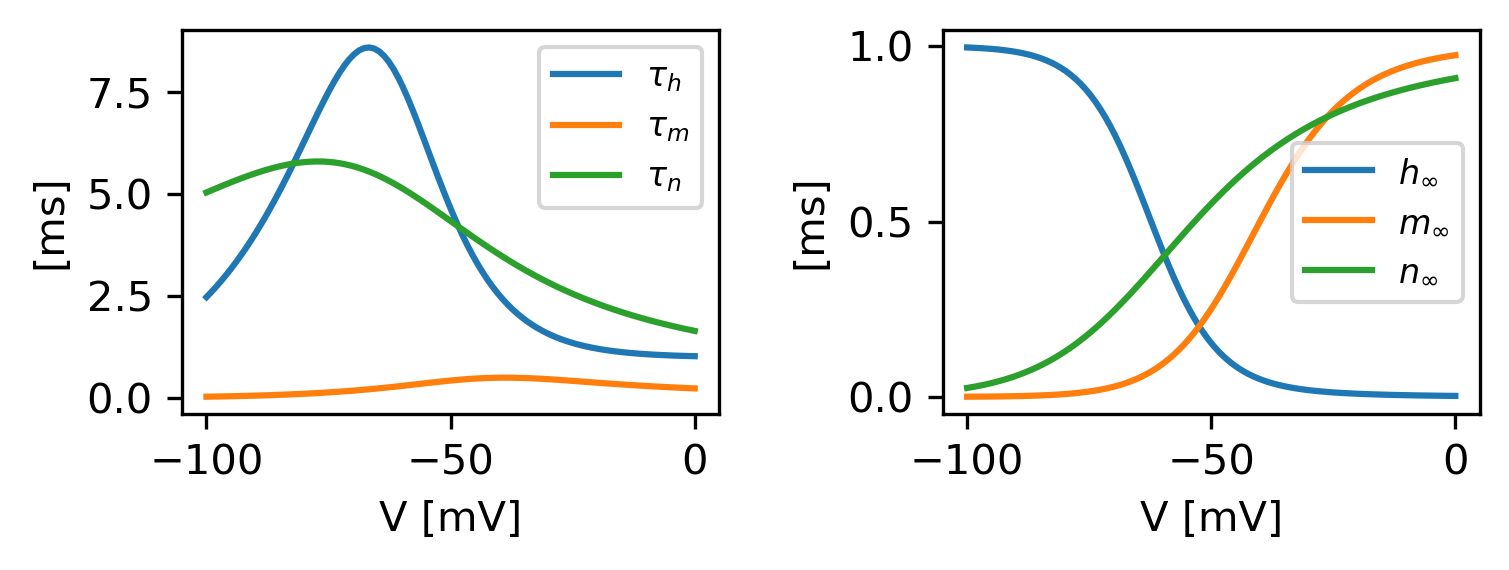

In [15]:
v_ms = np.linspace(-100,0,100) # mV
alpha_h = hh_cell.alpha_h(v_ms)
beta_h = hh_cell.beta_h(v_ms)
alpha_m = hh_cell.alpha_m(v_ms)
beta_m = hh_cell.beta_m(v_ms)
alpha_n = hh_cell.alpha_n(v_ms)
beta_n = hh_cell.beta_n(v_ms)
tau_h = 1. / (alpha_h + beta_h)
tau_m = 1. / (alpha_m + beta_m)
tau_n = 1. / (alpha_n + beta_n)
x_infty_h = alpha_h * tau_h
x_infty_m = alpha_m * tau_m
x_infty_n = alpha_n * tau_n

plt.figure(dpi=300, figsize=(5,2))
plt.subplot(121)
plt.plot(v_ms, tau_h, label=r'$\tau_h$')
plt.plot(v_ms, tau_m, label=r'$\tau_m$')
plt.plot(v_ms, tau_n, label=r'$\tau_n$')
plt.ylabel('[ms]')
plt.xlabel('V [mV]')
plt.legend(fontsize=8)

plt.subplot(122)
plt.plot(v_ms, x_infty_h, label='$h_\infty$')
plt.plot(v_ms, x_infty_m, label='$m_\infty$')
plt.plot(v_ms, x_infty_n, label='$n_\infty$')
plt.ylabel('[ms]')
plt.xlabel('V [mV]')

plt.legend(fontsize=8)

plt.tight_layout()

## Aufgabe 7

Simulieren Sie das HH-Neuron unter Voltage-Clamp.

Erklären Sie das zeitliche Verhalten der Kanäle und Gatingvariablen? (Warum sind manche schneller bzw. langsamer?)

***Bemerkung zur Simulation:*** Zunächst wird die Spannung für 30 ms bei -70 mV gehalten. Nach 30 ms hat sie das System seinem Gleichgewichtszustand angenähert und die Spannung wird Stufenartig auf -30 mV erhöht.

tau_h = 1.5757374074334247 ms


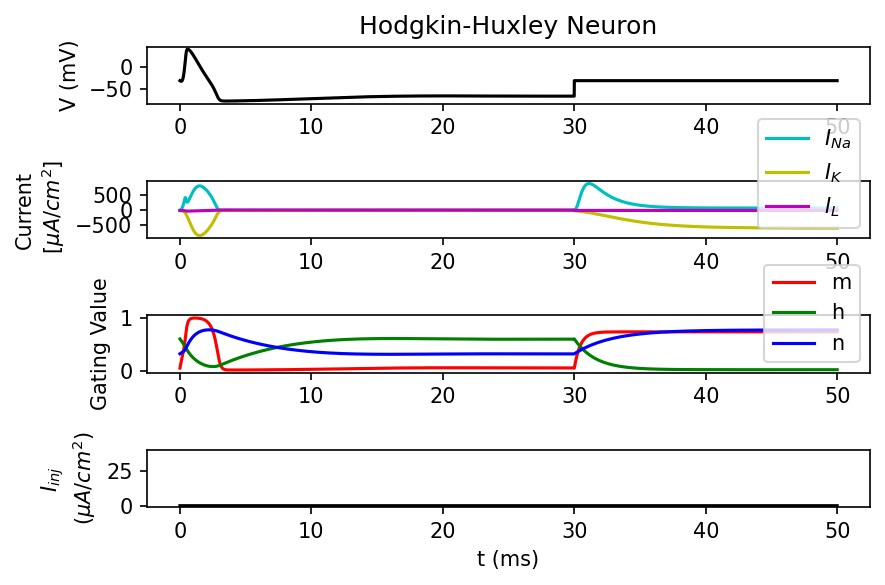

In [28]:
v_m = -30 # mV
hh_cell = HodgkinHuxley(v0 = -30, mode='voltage_clamp', run_time=50)
alpha_h = hh_cell.alpha_h(v_m)
beta_h = hh_cell.beta_h(v_m)
tau_h = 1. / (alpha_h + beta_h)
print('tau_h = '+ str(tau_h) +' ms')
hh_cell.run()

## Aufgabe 8

Wir untersuchen das Modell nun wieder im Current-Clamp Fall.

Führen Sie die folgende Code-Zelle aus und beantworten Sie anschaulich, basierend auf Ihren Ergebnissen aus den vorherigen Aufgaben die folgenden Fragen.

- Warum fließen die Ströme zeitlich versetzt?
- Warum schließen die Kanäle wieder?

Machen Sie sich klar welche Unterschiede zwischen Voltage Clamp und Current Clamp es gibt.



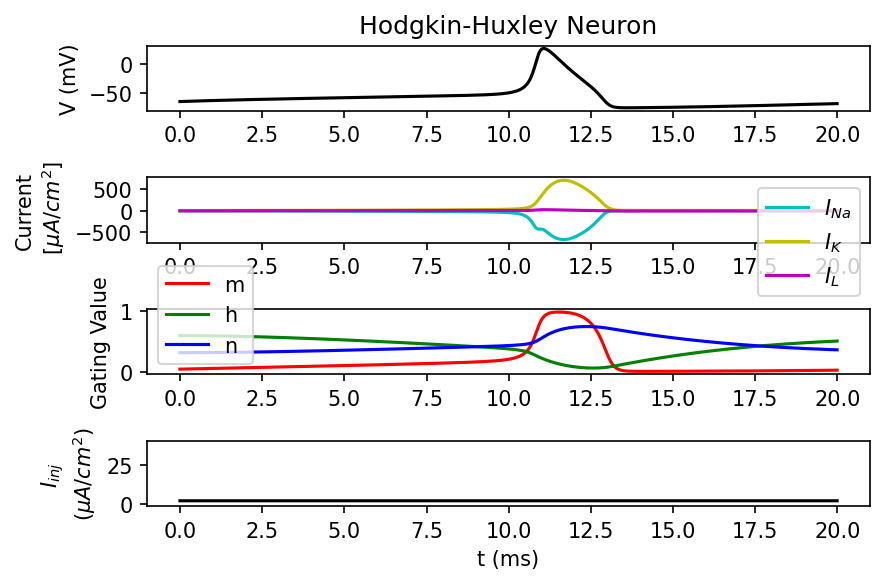

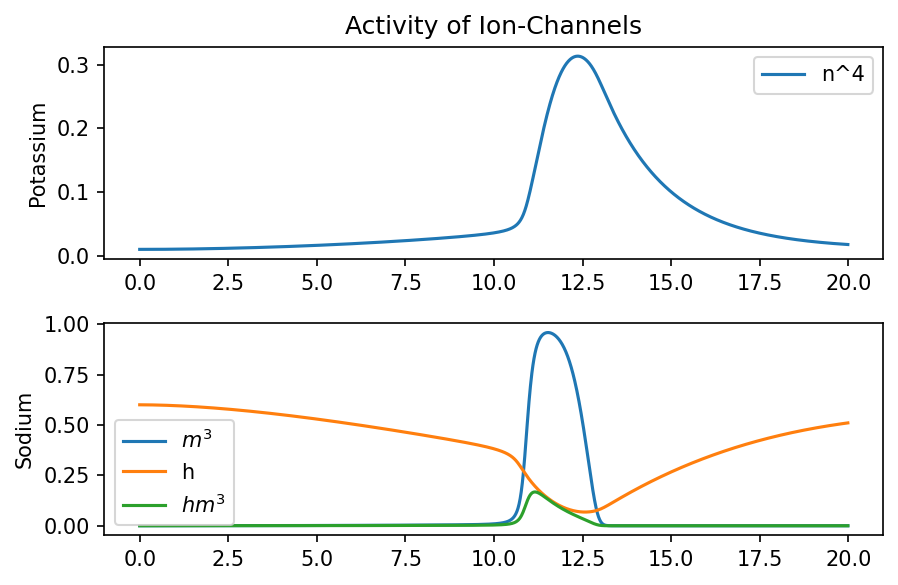

In [17]:
const_current_amplitude = 2.337 # muA/cm^2
i_constant = lambda t : const_current_amplitude
hh_cell = HodgkinHuxley(run_time=20, i_inj=i_constant)
hh_cell.run()
hh_cell.show_channel_open_prob()

## Aufgabe 9  Hopf-Bifurkation 

Im Hodgkin-Huxley-Modell führt eine Erhöhung des injezierten Stroms oberhalb einer Schwelle (Threshold) zu einer höheren Feuerrate des Neurons. Diese Schwelle entspricht einer Hopf-Bifurkation. Diese Bifurkation bewirkt eine minimale Feuerrate, wodurch das Neuron entweder nicht feuert oder mit der minimalen Rate feuert. Aufgrund des Alles-oder-Nichts-Prinzips gibt es keinen stetigen Anstieg der Aktionspotenzialamplitude, sondern einen plötzlichen "Sprung".

- Überprüfen Sie dieses Verhalten und finden Sie die minimale Feuerrate. Simulieren Sie dazu für 500 ms und verändern Sie den Strom. Finden Sie zunächst den Bifurkationspunkt. Nutzen Sie dann die Methode `get_average_firing_rate` um die Feuerrate zu berechnen.

- Varieren Sie dann den Strom Visualisieren Sie dann die Feuerrate als Funktion des Input-Stroms.

- Wodurch unterscheidet sich die Bifurkation vom Leaky-Integrate-and-Fire Neuron?

- Gibt es eine maximale Feuerrate? Variieren Sie dazu den Strom zwischen 60 und 70 $\mu A/cm^2$. Erklären Sie Ihre Beobachtung.

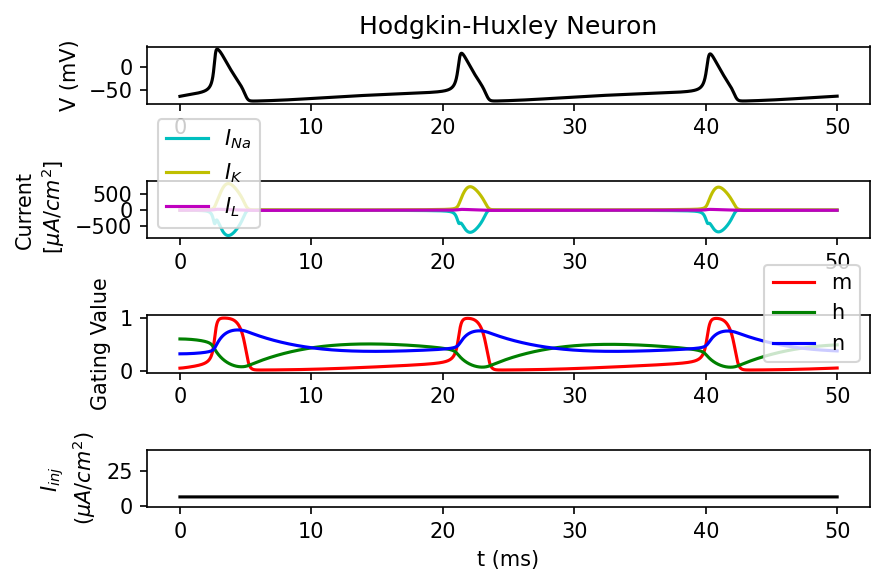

Rate: 60.0 Hz


In [18]:
const_current_amplitude = 6.3
i_constant = lambda t : const_current_amplitude
hh_cell = HodgkinHuxley(run_time=50, i_inj=i_constant)
hh_cell.run()
print('Rate:', hh_cell.get_average_firing_rate(), 'Hz')

2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0


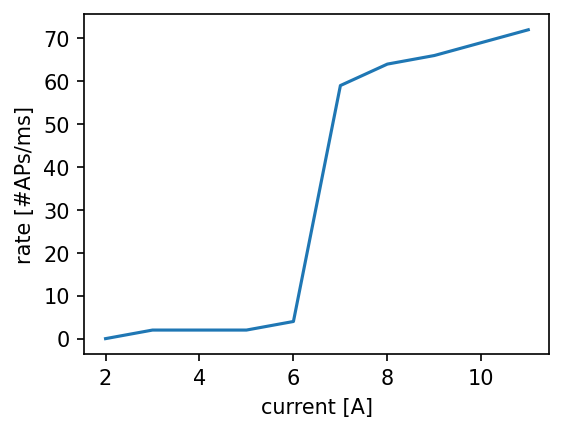

In [19]:
amps = [2. + 1.0*i for i in range(10)]
rates = []

for amp in amps:
    print(amp)
    const_current_amplitude = amp
    i_constant = lambda t : const_current_amplitude
    hh_cell = HodgkinHuxley(run_time=500, i_inj=i_constant)
    hh_cell.run(display_results=False)
    av_rate = hh_cell.get_average_firing_rate()
    rates.append(av_rate)
    
fig = plt.figure(dpi=150, figsize=(4,3))
ax = fig.add_subplot(111)
ax.plot(amps, rates)
ax.set_xlabel('current [A]')
ax.set_ylabel('rate [#APs/ms]')
plt.show()

## Aufgabe 10 Rebound Spike

Auch ein kurzer negativer Input-Strom kann zur Erzeugung eines einzelnen Aktionpotentials führen. Erklären Sie wie es dazu kommt.

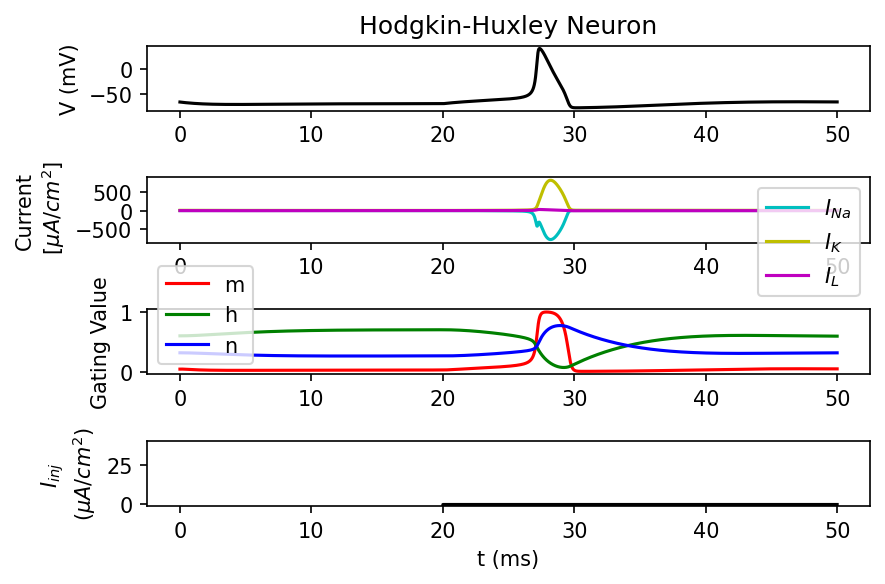

In [20]:
# REBOUND SPIKE
current_amplitude = -3.#50.
i_constant = lambda t : current_amplitude*(t<20)
hh_cell = HodgkinHuxley(run_time=50, i_inj=i_constant)
hh_cell.run()

<IPython.core.display.Javascript object>


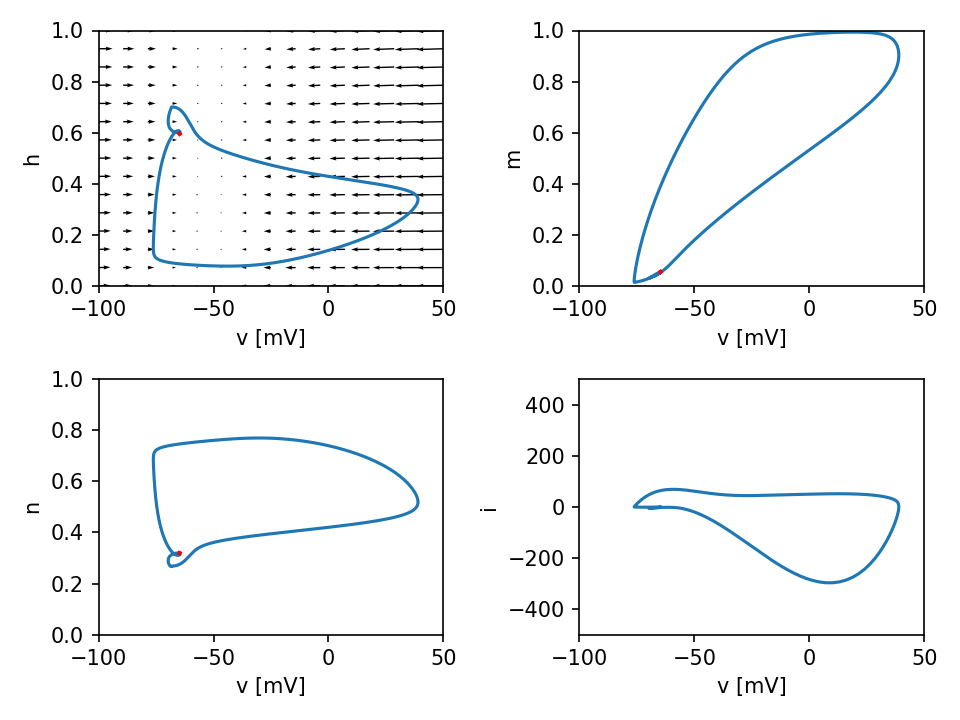

In [44]:
%matplotlib notebook
hh_cell.animation_phase_space_trajectory()

# Mögliche Klausurfragen zu den Tutorien:

- Erklären Sie den Unterschied zwischen Current Clamp und Voltage Clamp.

- Woran erkennt man, dass das Hodgkin-Huxley Modell eine Hopf-Bifurkation besitzt?

- Wie berechnet sich der Strom durch Kalium-Kanäle im Hodgkin-Huxley Modell?

- Analysiseren Sie ein Dynamisches System mit zwei abhängigen Variablen (siehe Woche 3 und 4).

- Analysiseren Sie ein Dynamisches System mit einer abhängigen Variablen (siehe Woche 1 und 2).


Welche der vier Möglichkeiten Findet eine Nullstelle der folgenden Python Funktion `f`?

`import numpy as np`\
`import scipy as sp`\
`f = lambda x: x**2 - 1.`
- `np.linalg.solve(f)`
- `sp.optimize.root(f, x0=-2)`
- `sp.integrate.odeint(f, t, 0)`
- `np.zeros(f,-1,1)`
